## Emotion Detection - Eye Version
#### By Kartik Muralimohan Pulipati


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
import warnings

import random
import os
from PIL import Image
import time

warnings.filterwarnings('ignore')
%matplotlib inline

### Experimenting with Data

In [3]:
path = 'data/archive-eyes/'
img_names = []
for folder,subFolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        print(folder+'/'+img)

data/archive-eyes/test/happy/img_test_happy_eye_1171.jpg
data/archive-eyes/test/happy/img_test_happy_eye_1165.jpg
data/archive-eyes/test/happy/img_test_happy_eye_1603.jpg
data/archive-eyes/test/happy/img_test_happy_eye_360.jpg
data/archive-eyes/test/happy/img_test_happy_eye_412.jpg
data/archive-eyes/test/happy/img_test_happy_eye_823.jpg
data/archive-eyes/test/happy/img_test_happy_eye_638.jpg
data/archive-eyes/test/happy/img_test_happy_eye_1415.jpg
data/archive-eyes/test/happy/img_test_happy_eye_1401.jpg
data/archive-eyes/test/happy/img_test_happy_eye_604.jpg
data/archive-eyes/test/happy/img_test_happy_eye_1429.jpg
data/archive-eyes/test/happy/img_test_happy_eye_162.jpg
data/archive-eyes/test/happy/img_test_happy_eye_957.jpg
data/archive-eyes/test/happy/img_test_happy_eye_31.jpg
data/archive-eyes/test/happy/img_test_happy_eye_25.jpg
data/archive-eyes/test/happy/img_test_happy_eye_943.jpg
data/archive-eyes/test/happy/img_test_happy_eye_994.jpg
data/archive-eyes/test/happy/img_test_happy_

In [6]:
len(img_names)

14102

In [12]:
img_sizes = []
rejected = []

for item in img_names:
        try:
                with Image.open(item) as img:
                       img_sizes.append(img.size)

        except:
                rejected.append(item)

print(len(img_sizes))
len(rejected)

17612


0

In [14]:
df_sizes = pd.DataFrame(img_sizes)
df_sizes.head()

,0,1
0,48,48
1,48,48
2,48,48
3,48,48
4,48,48


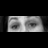

In [55]:
emotion = Image.open('data/archive-eyes/train/angry/img_train_angry_eye_10.jpg')
display(emotion)

<class 'torch.Tensor'>
torch.Size([3, 48, 48])


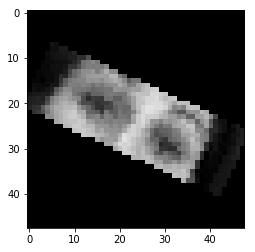

In [137]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1), #usually 0.5
        transforms.RandomRotation(30),
        transforms.ToTensor(),
])
tensorObj = transform(emotion)
print(type(tensorObj))
print(tensorObj.shape)
plt.imshow(np.transpose(tensorObj.numpy(), (1,2,0)))

### My Model

In [15]:
model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, padding=1),
    
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, padding=1),
    
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, padding=1),
    
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, padding=1),
    
        nn.Conv2d(128, 7, kernel_size=1, stride=1, padding=1),
        nn.ReLU(),
    
        nn.Conv2d(7, 7, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),

        nn.Flatten(),

        nn.Softmax(),
        )

### Loading in Data

In [5]:
train_transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(1),
        transforms.RandomRotation(30),
        transforms.RandomAffine(0,shear=0.3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

test_transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.ToTensor(),
])

In [6]:
train_data = datasets.ImageFolder(os.path.join(path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(path, 'test'), transform=test_transform)

train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32)

train_data.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Training the Model

In [41]:
L = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

epoch = 50

train_losses = []
test_losses = []

train_correct = []
test_correct = []

model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 7, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(7, 7, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Softmax(dim=None)
)

In [42]:
start_time = time.time()

for i in range(epoch):
        trn_correct = 0
        tst_correct = 0

        for b, (X_train, y_train) in enumerate(train_loader):
                y_pred = model(X_train)
                loss = L(y_pred, y_train)

                predicted = torch.max(y_pred, 1)[1]
                trn_correct += (predicted == y_train).sum()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if b%100 == 0:
                        print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000], loss: {loss.item():10.8f}')

                train_losses.append(loss)
                train_correct.append(trn_correct)

        with torch.no_grad():
                for b, (X_test, y_test) in enumerate(test_loader):
                        y_val = model(X_test)

                        predicted = torch.max(y_val.data, 1)[1]
                        tst_correct += (predicted == y_test).sum()

                        loss = L(y_val, y_test)
                        test_losses.append(loss)
                        test_correct.append(tst_correct)

total_time = time.time() - start_time

print(f'Total Time: {total_time/60} minutes')

epoch:  0  batch:    0 [     0/8000], loss: 3.33001137
epoch:  0  batch:  100 [  1000/8000], loss: 3.14176202
epoch:  0  batch:  200 [  2000/8000], loss: 2.98551202
epoch:  0  batch:  300 [  3000/8000], loss: 3.07926202
epoch:  0  batch:  400 [  4000/8000], loss: 3.07926202
epoch:  1  batch:    0 [     0/8000], loss: 3.32926202
epoch:  1  batch:  100 [  1000/8000], loss: 3.20426202
epoch:  1  batch:  200 [  2000/8000], loss: 3.17301202
epoch:  1  batch:  300 [  3000/8000], loss: 3.17301202
epoch:  1  batch:  400 [  4000/8000], loss: 3.04801202
epoch:  2  batch:    0 [     0/8000], loss: 3.01676202
epoch:  2  batch:  100 [  1000/8000], loss: 3.04801202
epoch:  2  batch:  200 [  2000/8000], loss: 3.07926273
epoch:  2  batch:  300 [  3000/8000], loss: 3.17301226
epoch:  2  batch:  400 [  4000/8000], loss: 3.17301226
epoch:  3  batch:    0 [     0/8000], loss: 2.98551273
epoch:  3  batch:  100 [  1000/8000], loss: 3.17301226
epoch:  3  batch:  200 [  2000/8000], loss: 3.07926345
epoch:  3 

In [27]:
#saving model
torch.save(model.state_dict(), 'Emotion_Eye_Model.pt')

### Evaluating Model

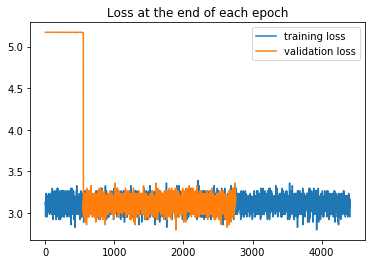

In [31]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

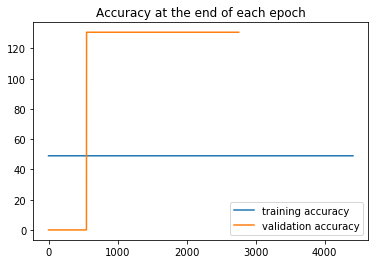

In [32]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [35]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3510:.3f}%')

[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)